In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform

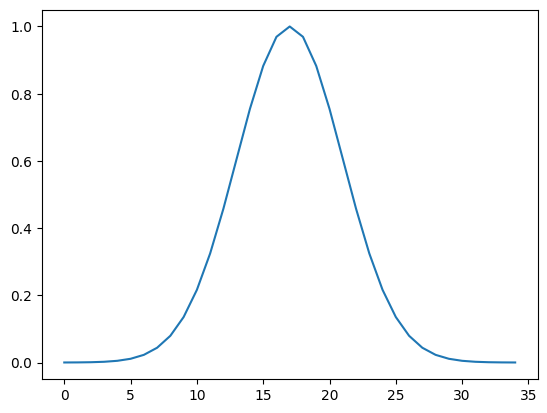

In [2]:
sigma = 4

kernel_size = int(4 * 4 + 1)
positions = np.arange(-kernel_size, kernel_size + 1, dtype=int)
gaussian_kernel = np.exp(-(positions**2) / (2 * sigma**2))

plt.plot(gaussian_kernel)

In [4]:
np.ones(gaussian_kernel.shape)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [10]:
# TEST np.stack

np.stack([np.ones(gaussian_kernel.shape), positions], axis=-1)

array([[  1., -17.],
       [  1., -16.],
       [  1., -15.],
       [  1., -14.],
       [  1., -13.],
       [  1., -12.],
       [  1., -11.],
       [  1., -10.],
       [  1.,  -9.],
       [  1.,  -8.],
       [  1.,  -7.],
       [  1.,  -6.],
       [  1.,  -5.],
       [  1.,  -4.],
       [  1.,  -3.],
       [  1.,  -2.],
       [  1.,  -1.],
       [  1.,   0.],
       [  1.,   1.],
       [  1.,   2.],
       [  1.,   3.],
       [  1.,   4.],
       [  1.,   5.],
       [  1.,   6.],
       [  1.,   7.],
       [  1.,   8.],
       [  1.,   9.],
       [  1.,  10.],
       [  1.,  11.],
       [  1.,  12.],
       [  1.,  13.],
       [  1.,  14.],
       [  1.,  15.],
       [  1.,  16.],
       [  1.,  17.]])

In [6]:
# ROW BASIS
basis_x = np.stack(
    [np.ones(gaussian_kernel.shape), positions, 
     np.ones(gaussian_kernel.shape), positions**2, 
     np.ones(gaussian_kernel.shape), positions
    ], 
     axis=-1
)

basis_x

array([[  1., -17.,   1., 289.,   1., -17.],
       [  1., -16.,   1., 256.,   1., -16.],
       [  1., -15.,   1., 225.,   1., -15.],
       [  1., -14.,   1., 196.,   1., -14.],
       [  1., -13.,   1., 169.,   1., -13.],
       [  1., -12.,   1., 144.,   1., -12.],
       [  1., -11.,   1., 121.,   1., -11.],
       [  1., -10.,   1., 100.,   1., -10.],
       [  1.,  -9.,   1.,  81.,   1.,  -9.],
       [  1.,  -8.,   1.,  64.,   1.,  -8.],
       [  1.,  -7.,   1.,  49.,   1.,  -7.],
       [  1.,  -6.,   1.,  36.,   1.,  -6.],
       [  1.,  -5.,   1.,  25.,   1.,  -5.],
       [  1.,  -4.,   1.,  16.,   1.,  -4.],
       [  1.,  -3.,   1.,   9.,   1.,  -3.],
       [  1.,  -2.,   1.,   4.,   1.,  -2.],
       [  1.,  -1.,   1.,   1.,   1.,  -1.],
       [  1.,   0.,   1.,   0.,   1.,   0.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   1.,   4.,   1.,   2.],
       [  1.,   3.,   1.,   9.,   1.,   3.],
       [  1.,   4.,   1.,  16.,   1.,   4.],
       [  

In [12]:
basis_y = np.stack(
   [np.ones(gaussian_kernel.shape), np.ones(gaussian_kernel.shape),
    positions, np.ones(gaussian_kernel.shape), 
    positions**2, positions
   ],
    axis=-1,
)

basis_y


array([[  1.,   1., -17.,   1., 289., -17.],
       [  1.,   1., -16.,   1., 256., -16.],
       [  1.,   1., -15.,   1., 225., -15.],
       [  1.,   1., -14.,   1., 196., -14.],
       [  1.,   1., -13.,   1., 169., -13.],
       [  1.,   1., -12.,   1., 144., -12.],
       [  1.,   1., -11.,   1., 121., -11.],
       [  1.,   1., -10.,   1., 100., -10.],
       [  1.,   1.,  -9.,   1.,  81.,  -9.],
       [  1.,   1.,  -8.,   1.,  64.,  -8.],
       [  1.,   1.,  -7.,   1.,  49.,  -7.],
       [  1.,   1.,  -6.,   1.,  36.,  -6.],
       [  1.,   1.,  -5.,   1.,  25.,  -5.],
       [  1.,   1.,  -4.,   1.,  16.,  -4.],
       [  1.,   1.,  -3.,   1.,   9.,  -3.],
       [  1.,   1.,  -2.,   1.,   4.,  -2.],
       [  1.,   1.,  -1.,   1.,   1.,  -1.],
       [  1.,   1.,   0.,   1.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   2.,   1.,   4.,   2.],
       [  1.,   1.,   3.,   1.,   9.,   3.],
       [  1.,   1.,   4.,   1.,  16.,   4.],
       [  

In [19]:
f1 = skimage.io.imread("data/ball/image1.tif").astype(np.double)[:,:,0]
f1 = skimage.io.imread("data/ball/image2.tif").astype(np.double)[:,:,0]

In [20]:
f1

array([[ 58.,  58.,  58., ..., 145., 145., 145.],
       [ 58.,  58.,  58., ..., 145., 145., 145.],
       [ 58.,  58.,  58., ..., 145., 145., 145.],
       ...,
       [188., 188., 190., ..., 171., 172., 173.],
       [190., 191., 192., ..., 170., 172., 174.],
       [192., 192., 193., ..., 171., 173., 175.]])

In [23]:
c1 = np.minimum(
    1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
)

c1

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0. , 0.2, 0.4, ..., 0.4, 0.4, 0.4],
       ...,
       [0. , 0.2, 0.4, ..., 1. , 1. , 1. ],
       [0. , 0.2, 0.4, ..., 1. , 1. , 1. ],
       [0. , 0.2, 0.4, ..., 1. , 1. , 1. ]])

In [24]:
c1 = np.minimum(
    c1,
    1 / 5 * np.minimum(
        f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
        f1.shape[1] - 1 - np.arange(f1.shape[1]),
    ),
)

c1

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.2, 0.2, ..., 0.2, 0.2, 0. ],
       [0. , 0.2, 0.4, ..., 0.4, 0.2, 0. ],
       ...,
       [0. , 0.2, 0.4, ..., 0.4, 0.2, 0. ],
       [0. , 0.2, 0.2, ..., 0.2, 0.2, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [26]:
weighted = f1 * c1
weighted

array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , 11.6, 11.6, ..., 29. , 29. ,  0. ],
       [ 0. , 11.6, 23.2, ..., 58. , 29. ,  0. ],
       ...,
       [ 0. , 37.6, 76. , ..., 68.4, 34.4,  0. ],
       [ 0. , 38.2, 38.4, ..., 34. , 34.4,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [28]:
cross_correlation_matrix = np.empty(list(f1.shape) + [basis_x.shape[-1]] * 2)

cross_correlation_matrix

array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]

In [30]:
solution_vector = np.empty(list(f1.shape) + [basis_x.shape[-1]])
solution_vector

array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        .

In [37]:
weighted_basis_x = np.einsum("i,ij->ij", gaussian_kernel, basis_x)
weighted_basis_x

array([[ 1.19612884e-04, -2.03341902e-03,  1.19612884e-04,
         3.45681234e-02,  1.19612884e-04, -2.03341902e-03],
       [ 3.35462628e-04, -5.36740205e-03,  3.35462628e-04,
         8.58784327e-02,  3.35462628e-04, -5.36740205e-03],
       [ 8.83826307e-04, -1.32573946e-02,  8.83826307e-04,
         1.98860919e-01,  8.83826307e-04, -1.32573946e-02],
       [ 2.18749112e-03, -3.06248757e-02,  2.18749112e-03,
         4.28748259e-01,  2.18749112e-03, -3.06248757e-02],
       [ 5.08606923e-03, -6.61189000e-02,  5.08606923e-03,
         8.59545700e-01,  5.08606923e-03, -6.61189000e-02],
       [ 1.11089965e-02, -1.33307958e-01,  1.11089965e-02,
         1.59969550e+00,  1.11089965e-02, -1.33307958e-01],
       [ 2.27941809e-02, -2.50735990e-01,  2.27941809e-02,
         2.75809589e+00,  2.27941809e-02, -2.50735990e-01],
       [ 4.39369336e-02, -4.39369336e-01,  4.39369336e-02,
         4.39369336e+00,  4.39369336e-02, -4.39369336e-01],
       [ 7.95595087e-02, -7.16035578e-01,  7.955